In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.models.mucsvss_model import MUCSVSSModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.cov_bhm_model import CovBHMModel


muc_model = MUCSVSSModel(num_particles=100008, stochastic_seasonality=True)
muc_model.load_from_disk("../../models/mucsvss_model_100008_deterministic_all.pkl")
muc_model

c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [4]:
df = read_merged().reset_index()


c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:173: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:409: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


In [5]:
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

# Try multistep ahead UCSVSS model

In [5]:
UCSV = UCSVSSModel(num_particles = 10000, stochastic_seasonality=False)
UCSV.full_fit(df)
UCSV

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 1112.47it/s]


In [6]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(UCSV, df, "2010-01-01", h=1)
forecast

inflation        country       date
0      0.000124          Japan 2010-01-01
1      0.004801         Canada 2010-01-01
2      0.006586  United States 2010-01-01
3      0.006888      Australia 2010-01-01
4      0.006481    New Zealand 2010-01-01
...         ...            ...        ...
1055   0.007293         Norway 2023-01-01
1056   0.029420        Belgium 2023-01-01
1057   0.006645          Korea 2023-01-01
1058   0.012935   South Africa 2023-01-01
1059   0.028585        Türkiye 2021-01-01

[1060 rows x 3 columns]

In [7]:
from seminartools.models.utils import make_oos_predictions

forecast = make_oos_predictions(lambda: UCSVSSModel(num_particles = 1000, stochastic_seasonality=False), df,tss,h=4)
forecast

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x7f43bc509c10>)


100%|██████████| 20/20 [00:00<00:00, 4049.34it/s]

Fitted!


inflation        country       date
0      0.001653          Japan 2000-01-01
1      0.002556         Canada 2000-01-01
2      0.004002  United States 2000-01-01
3      0.000940      Australia 2000-01-01
4     -0.000287    New Zealand 2000-01-01
...         ...            ...        ...
1821   0.005956         Norway 2023-01-01
1822   0.030965        Belgium 2023-01-01
1823   0.006170          Korea 2023-01-01
1824   0.012872   South Africa 2023-01-01
1825   0.031949        Türkiye 2021-10-01

[1826 rows x 3 columns]

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\models\armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\models\armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\models\armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

date        country  inflation
0    2000-01-01          Japan  -0.007854
1    2000-01-01         Canada  -0.008615
2    2000-01-01  United States   0.004917
3    2000-01-01      Australia   0.003646
4    2000-01-01    New Zealand   0.000415
...         ...            ...        ...
1516 2023-01-01         Norway   0.004521
1517 2023-01-01        Belgium   0.012320
1518 2023-01-01          Korea   0.010256
1519 2023-01-01   South Africa   0.009348
1520 2021-10-01        Türkiye   0.031694

[1521 rows x 3 columns]

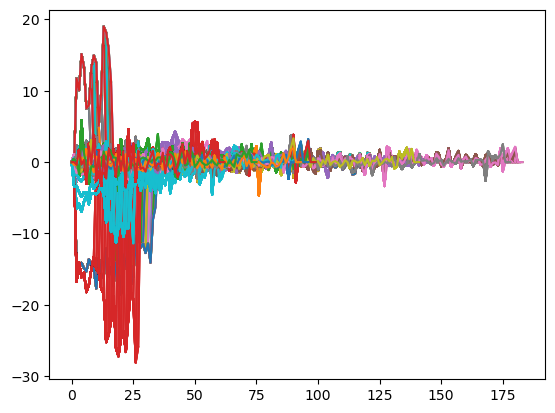

In [6]:
from seminartools.models.utils import make_oos_predictions

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]
forecast = make_oos_predictions(lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns), df,tss,h=4)
forecast

In [9]:
f = forecast['inflation']
f


0      -0.007854
1      -0.008615
2       0.004917
3       0.003646
4       0.000415
          ...   
1516    0.004521
1517    0.012320
1518    0.010256
1519    0.009348
1520    0.031694
Name: inflation, Length: 1521, dtype: float64

# 1. Get stats for four steps ahead forecast

c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message w

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x000001DD5D4DC350>)


100%|██████████| 20/20 [00:00<00:00, 89.42it/s]


Fitted!


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x000001DD5B9EE690>)


100%|██████████| 20/20 [00:00<00:00, 1191.16it/s]


Fitted!


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Creating regression coefficients: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
Creating regression coefficients: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Creating regression coefficients: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Creating regression coefficients: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Creating regression coefficients: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Creating regression coefficients: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
Creating regression coefficients: 100%|██████████| 1/1 [00:00<00:00, 59.72it/s]


Creating regression coefficients: 100%|██████████| 1/1 [00:00<00:00, 64.45it/s]


Creating regression coefficients: 100%|██████████| 1/1 [00:00<?, ?it/s]


Creating regression coefficients: 100%|██████████| 1/1 [00:00<00:00, 122.29it/s]


Creating regression coefficients: 100%|██████████| 1/1 [00:00<00:00, 342.92it/s]


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
Creating regression coefficients: 100%|██████████| 9/9 [00:00<00:00, 104.01it/s]


Creating regression coefficients: 100%|██████████| 9/9 [00:00<00:00, 152.85it/s]


Creating regression coefficients: 100%|██████████| 9/9 [00:00<00:00, 127.26it/s]


Creating regression coefficients: 100%|██████████| 9/9 [00:00<00:00, 133.65it/s]


Creating regression coefficients: 100%|██████████| 9/9 [00:00<00:00, 122.46it/s]


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Fitting model on the full dataset... (model=<seminartools.models.mucsvss_model.MUCSVSSModel object at 0x000001DD44199090>)
Fitted!


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


mse       mae           r2  mz_intercept  mz_slope  \
cov_bhm           0.000056  0.005334     0.210040     -0.000616  1.023849   
ar                0.000056  0.005374     0.245409     -0.001172  1.075904   
4qa               0.000056  0.005302     0.207971      0.002048  0.734753   
distance          0.000056  0.005355     0.204941     -0.000311  0.979191   
random_effects    0.000057  0.005402     0.195971     -0.000923  1.054933   
arma              0.000057  0.005344     0.231634      0.000870  0.824800   
random_effects_x  0.000058  0.005431     0.177139      0.001593  0.889167   
uc_sv             0.000059  0.005384     0.167159      0.001697  0.812925   
distance_x        0.000064  0.005748     0.096927      0.002854  0.628424   
cov_bhm_x         0.000064  0.005766     0.095058      0.002953  0.632379   
pca_var           0.000065  0.005733     0.043271      0.003374  0.644332   
uc_sv_ss          0.000082  0.006682    -0.168534      0.004549  0.325109   
mucsvss           0.000263  0.011498    -2.723450      0.005987  0.059241   
arx               0.001038  0.013307   -12.991657      0.006238 -0.031685   
armax             0.130854  0.064804 -1762.842761      0.006010 -0.003987   

                     mz_r2  mz_wald_test_statistic                 p-value  
cov_bhm           0.213139            3.160176e+00     0.04268234516046768  
ar                0.252410            6.780542e+00   0.0011720659220077164  
4qa               0.244055            4.050185e+01   6.564188391349138e-18  
distance          0.207870            2.967459e+00     0.05171609269960899  
random_effects    0.200909            4.959523e+00    0.007124176630618404  
arma              0.243535            1.139102e+01  1.2344050665604576e-05  
random_effects_x  0.195165            1.797395e+01   1.906098901912461e-08  
uc_sv             0.182282            1.621073e+01  1.0570124634299513e-07  
distance_x        0.167786            6.832903e+01  3.3189029874652224e-29  
cov_bhm_x         0.170205            7.267548e+01   6.106547483227444e-31  
pca_var           0.136762            9.108236e+01   2.769339906275486e-38  
uc_sv_ss          0.048440            1.998591e+02   6.480227960281782e-79  
mucsvss           0.010842            2.422875e+03                     0.0  
arx               0.011975            9.528734e+03                     0.0  
armax             0.027217            1.312028e+06                     0.0

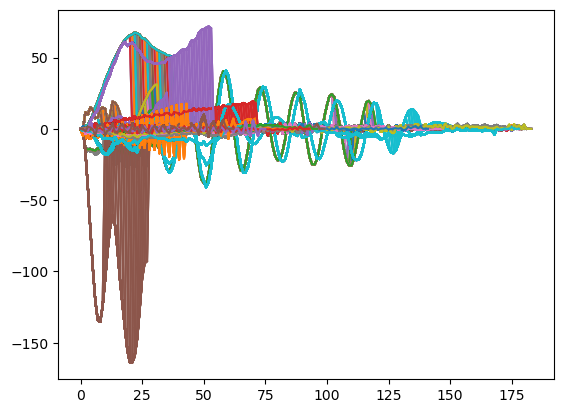

In [8]:
from seminartools.models.utils import get_stats

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
         ("4qa", lambda: FourQuarterAverageModel()),
        ("pca_var", lambda: PCAVARModel()),
         ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
         (
             "arx",
             lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns),
         ),
         ("arma", lambda: ARMAXModel(max_p=2, max_q=2)),
         (
             "armax",
             lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns=exog_columns),
         ),
         (
             "uc_sv",
             lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False),
         ),
         (
             "uc_sv_ss",
             lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=True),
         ),
         ("random_effects", lambda: RandomEffectsModel()),
         (
             "random_effects_x",
             lambda: RandomEffectsModel(exogenous_columns=exog_columns),
         ),
         ("distance", lambda: DistanceModel()),
         ("distance_x", lambda: DistanceModel(exogenous_columns=exog_columns)),
         ("cov_bhm", lambda: CovBHMModel()),
         ("cov_bhm_x", lambda: CovBHMModel(exogenous_columns=exog_columns)),
         ("mucsvss", lambda: muc_model),
    ],
    df,
    tss,
    h=4,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
    num_cores_parallel_splits=1
)
stats

In [9]:
# format r2 column to 2 
format_stats = stats.copy()
format_stats['p-value'] =format_stats['p-value'].astype(float)
round_cols = ["r2", "mz_intercept", "mz_slope", "mz_r2", "mz_wald_test_statistic", "p-value"]
for col in round_cols:
    format_stats[col] = format_stats[col].apply(lambda x: round(x, 3))

format_stats['mz_wald_test_statistic'] = format_stats['mz_wald_test_statistic'].astype(str) + '(' + format_stats['p-value'].astype(str) + ')'
format_stats.drop(columns = ['p-value'], inplace = True)

# get relative to UCSV
format_stats.loc[:,["mse","mae"]] = format_stats.loc[:,["mse","mae"]].div(format_stats.loc["uc_sv",["mse","mae"]])
format_stats

C:\Users\vandi\AppData\Local\Temp\ipykernel_25788\595229972.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.9503177830981847 0.9533366093767984 0.9549618223573704
 0.9564520496209696 0.9672438458942917 0.9707400643966174
 0.9898983987942851 1.0 1.0863932823461249 1.0886411338256272
 1.1095744044915123 1.4030696282065471 4.470781096561083 17.67680428731122
 2228.4067166934437]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  format_stats.loc[:,["mse","mae"]] = format_stats.loc[:,["mse","mae"]].div(format_stats.loc["uc_sv",["mse","mae"]])
C:\Users\vandi\AppData\Local\Temp\ipykernel_25788\595229972.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.9907610184681129 0.9981298933704734 0.9848361299919105
 0.9945493374260692 1.0033389065384248 0.9924688753465918
 1.0087713688187117 1.0 1.0675110

mse        mae        r2  mz_intercept  mz_slope  \
cov_bhm              0.950318   0.990761     0.210        -0.001     1.024   
ar                   0.953337    0.99813     0.245        -0.001     1.076   
4qa                  0.954962   0.984836     0.208         0.002     0.735   
distance             0.956452   0.994549     0.205        -0.000     0.979   
random_effects       0.967244   1.003339     0.196        -0.001     1.055   
arma                  0.97074   0.992469     0.232         0.001     0.825   
random_effects_x     0.989898   1.008771     0.177         0.002     0.889   
uc_sv                     1.0        1.0     0.167         0.002     0.813   
distance_x           1.086393   1.067511     0.097         0.003     0.628   
cov_bhm_x            1.088641   1.070874     0.095         0.003     0.632   
pca_var              1.109574   1.064815     0.043         0.003     0.644   
uc_sv_ss              1.40307   1.241093    -0.169         0.005     0.325   
mucsvss              4.470781   2.135613    -2.723         0.006     0.059   
arx                 17.676804   2.471592   -12.992         0.006    -0.032   
armax             2228.406717  12.036259 -1762.843         0.006    -0.004   

                  mz_r2 mz_wald_test_statistic  
cov_bhm           0.213            3.16(0.043)  
ar                0.252           6.781(0.001)  
4qa               0.244            40.502(0.0)  
distance          0.208           2.967(0.052)  
random_effects    0.201            4.96(0.007)  
arma              0.244            11.391(0.0)  
random_effects_x  0.195            17.974(0.0)  
uc_sv             0.182            16.211(0.0)  
distance_x        0.168            68.329(0.0)  
cov_bhm_x         0.170            72.675(0.0)  
pca_var           0.137            91.082(0.0)  
uc_sv_ss          0.048           199.859(0.0)  
mucsvss           0.011          2422.875(0.0)  
arx               0.012          9528.734(0.0)  
armax             0.027       1312027.939(0.0)

In [11]:
# generate latex code for the stats table
print(
    # replace _ by \_ in columns and index
    format_stats.pipe(lambda df: df.rename(columns=lambda x: x.replace("_", "\\_")))
    .pipe(lambda df: df.rename(index=lambda x: x.replace("_", "\\_")))
    .to_latex(
        index=True,
        caption="MSPE, MAE, $R^2$, and Mincer-Zarnowitz statistics, out-of-sample, 2000-2023",
        label="tab:model_eval",
        float_format="%.4f",
    )
)

\begin{table}
\caption{MSPE, MAE, $R^2$, and Mincer-Zarnowitz statistics, out-of-sample, 2000-2023}
\label{tab:model_eval}
\begin{tabular}{lllrrrrl}
\toprule
 & mse & mae & r2 & mz\_intercept & mz\_slope & mz\_r2 & mz\_wald\_test\_statistic \\
\midrule
cov\_bhm & 0.9503 & 0.9908 & 0.2100 & -0.0010 & 1.0240 & 0.2130 & 3.16(0.043) \\
ar & 0.9533 & 0.9981 & 0.2450 & -0.0010 & 1.0760 & 0.2520 & 6.781(0.001) \\
4qa & 0.9550 & 0.9848 & 0.2080 & 0.0020 & 0.7350 & 0.2440 & 40.502(0.0) \\
distance & 0.9565 & 0.9945 & 0.2050 & -0.0000 & 0.9790 & 0.2080 & 2.967(0.052) \\
random\_effects & 0.9672 & 1.0033 & 0.1960 & -0.0010 & 1.0550 & 0.2010 & 4.96(0.007) \\
arma & 0.9707 & 0.9925 & 0.2320 & 0.0010 & 0.8250 & 0.2440 & 11.391(0.0) \\
random\_effects\_x & 0.9899 & 1.0088 & 0.1770 & 0.0020 & 0.8890 & 0.1950 & 17.974(0.0) \\
uc\_sv & 1.0000 & 1.0000 & 0.1670 & 0.0020 & 0.8130 & 0.1820 & 16.211(0.0) \\
distance\_x & 1.0864 & 1.0675 & 0.0970 & 0.0030 & 0.6280 & 0.1680 & 68.329(0.0) \\
cov\_bhm\_x & 1.08